数据仓库地址为：https://github.com/JAF963/homework2

所选数据集为：Wine Reviews——葡萄酒评论，数据集地址为：https://www.kaggle.com/zynicide/wine-reviews；

数据说明： 数据winemag-data_first150k.csv中，每条记录由11个变量组成，其中5个是标称属性，分别为：country、designation、province、variety和winery ；2个是数值属性，分别为points和price；

对数据集进行处理，转换成适合进行关联规则挖掘的形式；

保存处理后的数据集的dict, 保存标称属性和数值属性离散化后的值

In [1]:
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')
import csv
import math
import numpy as np
np.set_printoptions(threshold=np.inf)
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

import itertools

filename = '/Users/yumingfei/Documents/Document/Postgraduate/课件/数据挖掘/数据集/wine-reviews/winemag-data_first150k.csv'
header = True
print('[data] read', filename)


[data] read /Users/yumingfei/Documents/Document/Postgraduate/课件/数据挖掘/数据集/wine-reviews/winemag-data_first150k.csv


In [2]:
data_content = dict()

# 标称属性
country = dict()
designation = dict()
province = dict()
variety = dict()
winery = dict()
# 数值属性 经过离散化处理后保存
points = dict()
price = dict()

In [3]:
# 读取文件并进行响应处理
with open(filename, 'r') as fin:
    reader = csv.reader(fin)
    rownum = 0
    cnt = 0

    # 每一行数据
    for line in reader:
        if header and rownum == 0:
            header = line
            print('header: ', header)
        else:
            # 标称属性
            c = line[1]
            d = line[3]
            p = line[6]
            v = line[9]
            w = line[10]
            # 数值属性
            po = line[4]  # 80-100
            pr = line[5]  # 4-76-2300

            # 当所有数据均完整，则保存数据
            if c and d and p and v and w and po and pr:
                if c in country.keys():
                    country[c] += 1
                else:
                    country[c] = 1

                if d in designation.keys():
                    designation[d] += 1
                else:
                    designation[d] = 1

                if p in province.keys():
                    province[p] += 1
                else:
                    province[p] = 1

                if v in variety.keys():
                    variety[v] += 1
                else:
                    variety[v] = 1

                if w in winery.keys():
                    winery[w] += 1
                else:
                    winery[w] = 1

                m = (round(float(po)) - 80) // 6 + 1
                if m in points.keys():
                    points[m] += 1
                else:
                    points[m] = 1

                n = (round(float(pr)) - 4) // 19 + 1
                if round(float(pr)) > 76:
                    n = 5
                if n in price.keys():
                    price[n] += 1
                else:
                    price[n] = 1

                m = 'points_' + str(m)
                n = 'price_' + str(n)
                data_content[cnt] = [c, d, p, v, w, m, n]
                cnt += 1



        rownum += 1
        # if rownum == 5:
        #     break

# 数据项总数目
total = len(data_content)
print(total)

header:  ['', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety', 'winery']
94919


找出频繁模式，利用Apriori算法

In [4]:
# 定义Apriori类
class Apriori:
    def __init__(self, min_sup=0.2, dataDic={}):
        # 事务数据库data
        self.data = dataDic

        # 获取事务的数量
        self.size = len(dataDic)

        # 最小支持度阈值
        self.min_sup = min_sup
        self.min_sup_val = min_sup * self.size

    # 找出频繁1项集的集合L1
    def find_frequent_1_itemsets(self):
        # 这里的字典格式设置为: {itemset1:freq1,itemsets2:freq2}
        FreqDic = {}

        # 保存frequent-1
        L1_item  = dict()

        for event in self.data:
            for item in self.data[event]:
                if item in FreqDic:
                    FreqDic[item] += 1
                else:
                    FreqDic[item] = 1
        L1 = []
        for itemset in FreqDic:
            if FreqDic[itemset] >= self.min_sup_val: # itemset >= self.min_sup_val
                L1.append([itemset])  # L1.append([itemset])
                L1_item[itemset] = FreqDic[itemset]

        return L1, L1_item

    # 实现连接和剪枝
    def apriori_gen(self, L_last):
        k = len(L_last[0]) + 1
        Ck = []
        for itemset1 in L_last:
            for itemset2 in L_last:
                # 连接步：产生候选
                flag = 0
                for i in range(k - 2):
                    if itemset1[i] != itemset2[i]:
                        flag = 1
                        break;
                if flag == 1:
                    continue
                # print("-----", itemset1[k - 2], itemset2[k - 2])
                if itemset1[k - 2] < itemset2[k - 2]:
                    c = itemset1 + [itemset2[k - 2]]
                else:
                    continue

                # 剪枝步：删除非频繁的候选
                if self.has_infrequent_subset(c, L_last, k):
                    continue
                else:
                    Ck.append(c)
        return Ck

    # 使用先验知识
    def has_infrequent_subset(self, c, L_last, k):
        # 返回列表中元组的项
        subsets = list(itertools.combinations(c, k - 1))
        for each in subsets:
            # 将元组转换成列表
            each = list(each)
            if each not in L_last:
                return True
        return False

    # 运行Apriori算法
    def run(self):
        L_last, _ = self.find_frequent_1_itemsets()
        L = L_last
        i = 0
        j = 2
        # 保存frequent-2
        L2_item = dict()

        while L_last != []:
            Ck = self.apriori_gen(L_last)
            FreqDic = {}
            for event in self.data:
                # 获取所有支持的子集
                for c in Ck:
                    # 判断是否是子集
                    if set(c) <= set(self.data[event]):
                        if tuple(c) in FreqDic:
                            FreqDic[tuple(c)] += 1
                        else:
                            FreqDic[tuple(c)] = 1

            Lk = []
            num = []
            Lo = []
            for c in FreqDic:
                if FreqDic[c] > self.min_sup_val:
                    Lk.append(list(c))
                    num.append(FreqDic[c])

            L_last = Lk
            L += Lk

            if len(Lk) != 0:
                # print("[*] 频繁%d项集L%d：" % (j, j))
                for i in range(0, len(Lk)):
                    # print(Lk[i], ':', num[i])

                    content = ""
                    for j in range(len(Lk[i])):
                        content = content + Lk[i][j] + '+'
                    content = content[:-1]
                    L2_item[content] = num[i]
                j += 1

        return L, L2_item

In [6]:
a = Apriori(dataDic=data_content)
L1, L1_item = a.find_frequent_1_itemsets()
result, L2_item = a.run()
L2 = []


print("[*] 所有的频繁项集：")
for r in result:
    print(r)

print()
len_L1 = len(L1)
print("[*] 频繁%d项集L%d：" % (1, 1))
print(len_L1)
for item in L1_item.keys():
    print(item, ':', L1_item[item])

print()
len_L2 = len(L2_item)
print(len_L2)
print("[*] 频繁%d项集L%d：" % (2, 2))
for item in L2_item.keys():
    L2.append(item)
    print(item, ':', L2_item[item])

[*] 所有的频繁项集：
['US']
['California']
['price_2']
['points_2']
['price_1']
['points_1']
['California', 'US']
['points_2', 'price_1']
['US', 'points_2']
['points_2', 'price_2']

[*] 频繁1项集L1：
6
US : 40155
California : 28683
price_2 : 30286
points_2 : 59310
price_1 : 39176
points_1 : 20198

4
[*] 频繁2项集L2：
California+US : 28683
points_2+price_1 : 24506
US+points_2 : 23035
points_2+price_2 : 21636


导出关联规则，计算其支持度和置信度

In [7]:
# 对于frequent-2计算支持度和置信度
print()
support = []
confidence = []
for item in L2_item:
    num = L2_item[item]
    # 计算支持度
    sup = num / total
    support.append(sup)
    print('Support of', item, ':', sup)

    # 计算置信度
    condition = item.split('+')[0]
    condition_num = L1_item[condition]
    conf = num / condition_num
    confidence.append(conf)
    print('Confidence of', item, ':', conf)


Support of California+US : 0.3021839673827158
Confidence of California+US : 1.0
Support of points_2+price_1 : 0.2581780254743518
Confidence of points_2+price_1 : 0.4131849603776766
Support of US+points_2 : 0.24268060135483938
Confidence of US+points_2 : 0.5736520981197858
Support of points_2+price_2 : 0.22794171872860017
Confidence of points_2+price_2 : 0.3647951441578149


对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种

这里使用Lift和Kulc两种方法进行评价

In [8]:
# 使用Lift方法
print()
lift_score = []
for item in L2_item:
    num = L2_item[item]

    its = item.split('+')
    first = L1_item[its[0]]
    second = L1_item[its[1]]
    lift = (num / total) / ((first/total) * (second/total))
    lift_score.append(lift)
    print('Lift of', item, ':', lift)


Lift of California+US : 2.363815216037853
Lift of points_2+price_1 : 1.0011002464286471
Lift of US+points_2 : 0.9180658152323713
Lift of points_2+price_2 : 1.1433002142348156


In [9]:
# 使用Kulc方法
print()
kulc_score = []
for item in L2_item:
    num = L2_item[item]

    its = item.split('+')
    first = L1_item[its[0]]
    second = L1_item[its[1]]

    first_pro = num / first
    second_pro = num / second
    kulc = (first_pro + second_pro) / 2
    kulc_score.append(kulc)

    print('Kulc of', 'item', ':', kulc)


Kulc of item : 0.857153530070975
Kulc of item : 0.5193605014263307
Kulc of item : 0.4810175850571952
Kulc of item : 0.539592315524724


对挖掘结果进行分析

通过Apriori算法进行筛选和检测，设定阈值min_sup=0.2，这里没有设定太高，因为数据较为分散；同时频繁模式分析适用于标称属性，这里共有5个，同时还有两个数值属性，为了对数据进行分析完全，对数值属性进行离散化处理，根据其最大最小值和四分位数，将数据划分合理区间；
因此对于数值属性points，分为4个区间，分别表示points_1, points_2, points_3, points_4，将这些标签作为标称属性，统计数值在这些区间内的值作为标称属性的频率；
对于数值属性price，分为五个区间，其中前四个区间为合理区间，与points类似，而第五个区间——price_5为异常值区间，将不在合理区间内的值放到该区间内，最后将这五个区间作为标称属性；
在这种情况下，满足要求的频繁模式共有10个，分别为：
['US']
['California']
['price_2']
['points_2']
['price_1']
['points_1']
['California', 'US']
['points_2', 'price_1']
['US', 'points_2']
['points_2', 'price_2']

其中，1-items共有6个，其名称和频率分别为：
US : 40155
California : 28683
price_2 : 30286
points_2 : 59310
price_1 : 39176
points_1 : 20198

2-items共有四个，其名称和频率分别为：
California+US : 28683
points_2+price_1 : 24506
US+points_2 : 23035
points_2+price_2 : 21636

对2-items进行分析，首先计算期支持度和置信度，分别为：
Support of California+US : 0.3021839673827158
Confidence of California+US : 1.0
Support of points_2+price_1 : 0.2581780254743518
Confidence of points_2+price_1 : 0.4131849603776766
Support of US+points_2 : 0.24268060135483938
Confidence of US+points_2 : 0.5736520981197858
Support of points_2+price_2 : 0.22794171872860017
Confidence of points_2+price_2 : 0.3647951441578149

这里对规则进行评价，分别采用Lift和Ku 两种方法，得到的结果分别为：
使用Lift方法：
Lift of California+US : 2.363815216037853
Lift of points_2+price_1 : 1.0011002464286471
Lift of US+points_2 : 0.9180658152323713
Lift of points_2+price_2 : 1.1433002142348156
使用Kulc方法：
Kulc of item : 0.857153530070975
Kulc of item : 0.5193605014263307
Kulc of item : 0.4810175850571952
Kulc of item : 0.539592315524724

对这两种方法进行评价，通过结果可以看出，Kulc方法更加合理鲁棒，值限制在[0，1]区间内，对Null-Invariant Measures也更加适合；

可视化展示

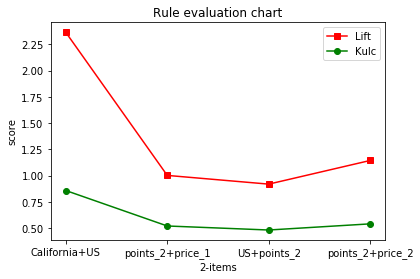

In [10]:
# 规则评价的结果折线图
x = L2  # 点的横坐标
k1 = lift_score # lift纵坐标
k2 = kulc_score  # kulc的纵坐标
plt.plot(x, k1, 's-', color = 'r', label="Lift")  #s-:方形
plt.plot(x, k2, 'o-', color = 'g', label="Kulc")  #o-:圆形
plt.xlabel("2-items")  # 横坐标名字
plt.ylabel("score")  # 纵坐标名字
plt.legend(loc="best")  # 图例
plt.title("Rule evaluation chart")
plt.show()

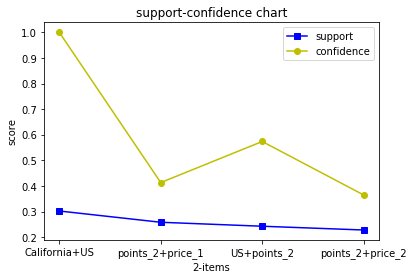

In [11]:
# 支持度和置信度的结果折线图
x = L2  # 点的横坐标
k1 = support # 支持度的纵坐标
k2 = confidence  # 置信度的纵坐标
plt.plot(x, k1, 's-', color = 'b', label="support")  #s-:方形
plt.plot(x, k2, 'o-', color = 'y', label="confidence")  #o-:圆形
plt.xlabel("2-items")  # 横坐标名字
plt.ylabel("score")  # 纵坐标名字
plt.legend(loc="best")  # 图例
plt.title("support-confidence chart")
plt.show()